# testing for molecules with 2+ charge with 2NH$_3$  

In [ ]:
import os
import random
from DECIMER import predict_SMILES
from ase.data.pubchem import pubchem_atoms_search, pubchem_atoms_conformer_search
from rdkit import Chem
from rdkit.Chem import AllChem
from ase.io import read, write 
import matplotlib.pyplot as plt
from ase.visualize import view
import matplotlib.pyplot as plt
import numpy as np
from ase import io, Atoms
from ase.visualize.plot import plot_atoms
from ase.atoms import Atoms
from ase.neighborlist import natural_cutoffs
from ase.build import sort
from ase.neighborlist import NeighborList
from ase.visualize import *
from ase.io import *
from ase.io.cif import read_cif
from ase.io.vasp import write_vasp
from ase.visualize.plot import plot_atoms
from ase.build import add_adsorbate
from ase.io.proteindatabank import read_proteindatabank, write_proteindatabank
from ase.io.lammpsdata import write_lammps_data
from ase.build import bulk, surface
from ase.build.tools import sort
import random
from ase.build import molecule
from ase.neighborlist import NeighborList


# Define atomic radii (in Angstroms)
atomic_radii = {
    'Cs': 2.62,
    'N': 1.55,
    'C': 1.70,
    # Add more atomic radii as needed
}

def nitrogen_with_most_bonds(molecule):
    """
    Find the nitrogen atom with the highest number of bonds.

    Args:
        molecule: An ASE Atoms object.

    Returns:
        Tuple containing the index of the nitrogen atom with the highest number of bonds
        and the number of bonds. Returns (None, 0) if no nitrogen atoms are found.
    """
    nitrogen_indices = [atom.index for atom in molecule if atom.symbol == 'N']
    
    if not nitrogen_indices:
        print('Nitrogen not found')
        return None, 0  # Return (None, 0) if no nitrogen atoms are found
    
    max_bond_count = 0
    nitrogen_index_with_most_bonds = None

    # Create a neighbor list
    cutoff_distance = natural_cutoffs(molecule)
    nl = NeighborList(cutoff_distance, self_interaction=False, bothways=True)
    nl.update(molecule)

    for i in nitrogen_indices:
        # Get neighbors of the nitrogen atom
        neighbors = nl.get_neighbors(i)[0]
        bond_count = len(neighbors)  # Count the number of bonded neighbors
    
        # Track nitrogen index with the most bonds
        if bond_count > max_bond_count:
            max_bond_count = bond_count
            nitrogen_index_with_most_bonds = i

    return nitrogen_index_with_most_bonds, max_bond_count


def rotate_molecule_towards_target(molecule, target_position):
    """
    Rotate the molecule so that nitrogen atoms are oriented towards the target position.
    
    Args:
        molecule: An ASE Atoms object.
        target_position: The position to orient the nitrogen atoms towards.
    """
    # Find nitrogen with the highest number of hydrogen neighbors
    #nh_index, hydrogen_count = nitrogen_with_highest_hydrogens(molecule)
    
    nh_index, max_bond_count = nitrogen_with_most_bonds(molecule)
    

    if nh_index is not None:
        print(f"Nitrogen atom at index {nh_index} has the highest number of bonded neighbors: {max_bond_count}")
    else:
        print("No nitrogen atoms found.")
    
    # Additional rotation logic goes here
    
    # For now, we only print the nh_index
    print(f"Index of nitrogen with most hydrogens: {nh_index}")
    
    # Calculate the average position of nitrogen atoms
    nitrogen_positions = molecule.positions[[nh_index]]
    avg_nitrogen_pos = np.mean(nitrogen_positions, axis=0)

    # Vector from average nitrogen position to target position    
    direction = target_position - avg_nitrogen_pos
    direction[2] = 0  # Only consider x-y plane for rotation
    direction /= np.linalg.norm(direction)

    # Define the direction we want the nitrogen to face (downward)
    target_direction = np.array([0, 0, 1])  # Pointing down

    # Calculate the angle between the current direction and target direction
    angle = np.arccos(np.clip(np.dot(direction, target_direction), -1.0, 1.0))
    
    #print(angle)
    #print(direction)
    
    # Axis of rotation (cross product)
    rotation_axis = np.cross(direction, target_direction)
    if np.linalg.norm(rotation_axis) == 0:
        print('No rotation needed')
        return  # No rotation needed

    rotation_axis /= np.linalg.norm(rotation_axis)
    
    # Create rotation matrix using Rodrigues' rotation formula
    cos_angle = np.cos(angle)
    sin_angle = np.sin(angle)
    rotation_matrix = np.array([
        [cos_angle + rotation_axis[0]**2 * (1 - cos_angle),
         rotation_axis[0] * rotation_axis[1] * (1 - cos_angle) - rotation_axis[2] * sin_angle,
         rotation_axis[0] * rotation_axis[2] * (1 - cos_angle) + rotation_axis[1] * sin_angle],
        [rotation_axis[1] * rotation_axis[0] * (1 - cos_angle) + rotation_axis[2] * sin_angle,
         cos_angle + rotation_axis[1]**2 * (1 - cos_angle),
         rotation_axis[1] * rotation_axis[2] * (1 - cos_angle) - rotation_axis[0] * sin_angle],
        [rotation_axis[2] * rotation_axis[0] * (1 - cos_angle) - rotation_axis[1] * sin_angle,
         rotation_axis[2] * rotation_axis[1] * (1 - cos_angle) + rotation_axis[0] * sin_angle,
         cos_angle + rotation_axis[2]**2 * (1 - cos_angle)]
    ])

    # Rotate the molecule
    molecule.positions = np.dot(molecule.positions - molecule.get_center_of_mass(), rotation_matrix.T) + molecule.get_center_of_mass()

def position_and_rotate_molecule(molecule, slab_position, atomic_radii):
    """Positions and rotates the molecule to bring nitrogen atoms closer to the slab."""
    # Calculate target position for nitrogen atoms
    slab_top = slab_position[2] + atomic_radii['C']  # Top of Cs
    target_z = slab_top + atomic_radii['N'] + 1.0  # Add buffer
    target_position = np.array([slab_position[0], slab_position[1], target_z])
    
    # Move the molecule's center of mass to the target position
    center_of_mass = molecule.get_center_of_mass()
    molecule.positions += target_position - center_of_mass


    # Rotate the molecule
    rotate_molecule_towards_target(molecule, target_position)


    # Ensure no penetration into the slab
    for atom in molecule:
        if atom.position[2] < slab_top:
            print("Molecule penetrates the slab. Adjusting...")
            adjustment = slab_top - atom.position[2] -0.1 # Additional space
            molecule.positions[:, 2] += adjustment
            break  # Adjust only once for simplicity

    return molecule

def automate_adsorption(slab_file, molecule_file, num_replace_FA, output_file=None):
    """Automates the adsorption process by replacing specified number of C atoms in a slab with a given molecule."""
    try:
        relaxed_slab = io.read(slab_file)
    except Exception as e:
        print(f"Error reading slab file: {e}")
        return

    try:
        molecule = molecule_file
        tmp_molecule = []

        for j in range(num_replace_FA):
            num_atoms = len(relaxed_slab.get_chemical_symbols())
            FA_index = [(relaxed_slab.positions[i, 2], i) 
                         for i in range(num_atoms) 
                         if relaxed_slab.get_chemical_symbols()[i] == 'C']

            if not FA_index:
                print("No FA molecules found for replacement.")
                break

            # Get the index of the C atom with the maximum z value
            max_value_z, idz = max(FA_index, key=lambda item: item[0])
            #print(max_value_z, idz)

            

            # Position and rotate the molecule
            slab_position = relaxed_slab.positions[idz]
            #print(slab_position)

            positioned_molecule = position_and_rotate_molecule(molecule.copy(), slab_position, atomic_radii)

            # Store the positioned molecule and remove the replaced Cs atom
            tmp_molecule = positioned_molecule if j == 0 else tmp_molecule + positioned_molecule

            species='C'

            atom_indices = [i for i, atom in enumerate(relaxed_slab) if atom.symbol == species]
            replacements = random.sample(atom_indices, min(1, len(atom_indices)))
            cutoff_distance=1.2
            nl = NeighborList([cutoff_distance] * len(relaxed_slab), self_interaction=False, bothways=True)
            nl.update(relaxed_slab)
        
            del_indices = []
            for idx in replacements:
                indices, _ = nl.get_neighbors(idz)
                for j in indices:
                    if relaxed_slab[j].symbol == 'N':
                        del_indices.append(j)
                        # Check neighbors of N
                        ind_1, _ = nl.get_neighbors(j)
                        del_indices.extend([k for k in ind_1 if relaxed_slab[k].symbol == 'H'])
               
        
            del relaxed_slab[del_indices]
            del relaxed_slab[idz]

        # Combine the relaxed slab and the new molecule
        new_slab = relaxed_slab + tmp_molecule
        # Visualize the structures
        fig, axes = plt.subplots(1, 3, figsize=(7, 7))
        visualize_structure(slab_file, new_slab, axes)

        # Save the final structure to a VASP file if specified
        if output_file:
            io.write(output_file, new_slab, vasp5=True, direct=True)
            print(f"Saved new slab structure to {output_file}")

    except Exception as e:
        print(f"An error occurred during the process: {e}")

def visualize_structure(slab_file, new_slab, axes):
    """Visualizes the original and new slab structures."""
    slab = io.read(slab_file)
    plot_atoms(slab, axes[0], radii=0.5, rotation=('90x,0y,0z'))
    axes[0].set_xlim(0, 25)
    axes[0].set_xlabel(r'x[$\AA$]')
    axes[0].set_ylabel(r'z[$\AA$]')
    axes[0].set_title('Original Slab')

    plot_atoms(new_slab, axes[1], radii=0.5, rotation=('90x,0y,0z'))
    axes[1].set_xlim(0, 25)
    axes[1].set_xlabel(r'x[$\AA$]')
    axes[1].set_ylabel(r'z[$\AA$]')
    axes[1].set_title('New Slab with Adsorbates')

    plot_atoms(new_slab, axes[2], radii=0.5, rotation=('0x,0y,0z'))
    axes[2].set_xlabel(r'x[$\AA$]')
    axes[2].set_ylabel(r'y[$\AA$]')
    axes[2].set_title('Side View of New Slab')
    #view(new_slab)
    plt.tight_layout()
    plt.show()



def SmilesToMol(smiles):
    """
    Converts a SMILES string to an RDKit molecule, adds hydrogens,
    embeds the molecule in 3D space, and optimizes it.
    
    Args:
        smiles (str): SMILES representation of the molecule.
    
    Returns:
        mol: An RDKit Mol object if successful, otherwise None.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"Failed to create molecule from SMILES: {smiles}")
        return None
    
    # Add hydrogens to the molecule
    hmol = Chem.AddHs(mol)
    
    # Embed molecule in 3D space
    AllChem.EmbedMolecule(hmol)
    
    # Optimize the 3D structure
    AllChem.MMFFOptimizeMolecule(hmol)
    
    return hmol

def contains_nitrogen(mol):
    """
    Checks if the given molecule contains a nitrogen atom.
    
    Args:
        mol: An RDKit Mol object.
    
    Returns:
        bool: True if nitrogen is present, False otherwise.
    """
    return any(atom.GetSymbol() == 'N' for atom in mol.GetAtoms())



def process_images_in_folder(folder_path):
    # Iterate through all files in the specified folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.png'):  # Change this if you need other formats
            image_path = os.path.join(folder_path, filename)

            # Predict SMILES from the image
            SMILES = predict_SMILES(image_path)
            split_smiles = SMILES.split(sep='.')
            
            # Find the first fragment containing nitrogen
            organic_mol = None
            for smiles_fragment in split_smiles:
                mol = SmilesToMol(smiles_fragment)
                if mol and contains_nitrogen(mol):
                    organic_mol = mol
                    break

            if organic_mol is None:
                raise ValueError("No organic fragment containing nitrogen was found.")

            # Save the organic fragment containing nitrogen to a .mol file
            Chem.MolToMolFile(organic_mol, f'{filename}_test.mol')

            # Read the .mol file with ASE
            molecule = read(f'{filename}_test.mol')

            # Plot the molecule
            fig, axes = plt.subplots(1, 1, figsize=(4, 4))
            plot_atoms(molecule, axes, radii=0.5, rotation=('0x,0y,0z'))
            plt.show()

            # Perform adsorption automation (you may want to customize this)
            # Define the folder where you want to save the output
            output_folder = 'Hong_passivation_mixed'

            # Create the folder if it does not exist
            os.makedirs(output_folder, exist_ok=True)

            # Define the output file path
            output_file = os.path.join(output_folder, f'{filename}_slab.vasp')
            
            automate_adsorption('surface_001.vasp', molecule, num_replace_FA=2, output_file=output_file)

            # Load the slab for visualization
            #slab = read(output_file)
            #view(slab, viewer='ngl')

# Example usage
folder_path = "./test_N2+/"
process_images_in_folder(folder_path)

In [ ]:
# Load the slab for visualization
slab = read('Hong_passivation_mixed/PDAI.png_slab.vasp')
view(slab, viewer='ngl')

In [ ]:
atoms = read(output_file)
view(atoms)

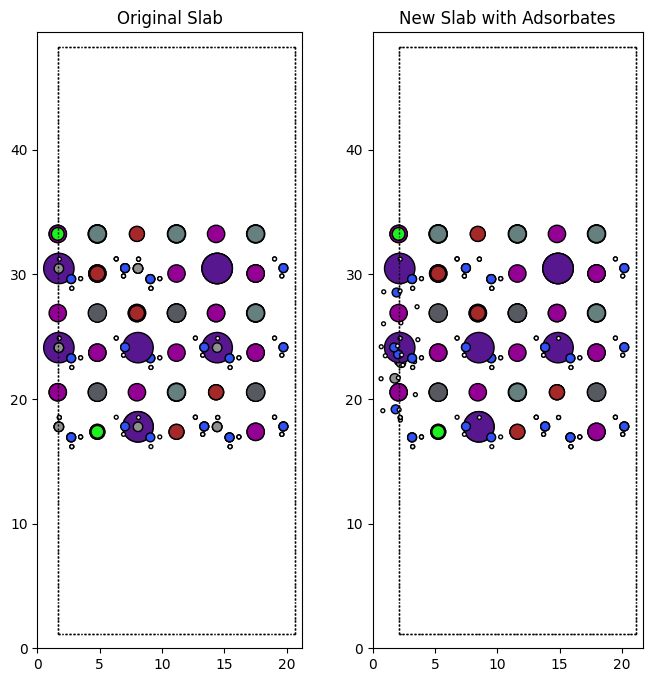

Saved modified slab to Hong_passivation_mixed/PDAI.png_slab.vasp


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms, io
from ase.io import read, write
from ase.visualize.plot import plot_atoms
from ase.neighborlist import NeighborList, natural_cutoffs
from rdkit import Chem
from rdkit.Chem import AllChem
from DECIMER import predict_SMILES


# Define atomic radii (in Angstroms)
atomic_radii = {
    'Cs': 2.62,
    'N': 1.55,
    'C': 1.70,
}


def nitrogen_with_most_bonds(molecule):
    """
    Find the nitrogen atom with the highest number of bonds.
    """
    nitrogen_indices = [atom.index for atom in molecule if atom.symbol == 'N']
    if not nitrogen_indices:
        print('No nitrogen atoms found.')
        return None, 0
    
    max_bond_count = 0
    nitrogen_index_with_most_bonds = None
    cutoff_distance = natural_cutoffs(molecule)
    nl = NeighborList(cutoff_distance, self_interaction=False, bothways=True)
    nl.update(molecule)

    for i in nitrogen_indices:
        neighbors = nl.get_neighbors(i)[0]
        bond_count = len(neighbors)
        if bond_count > max_bond_count:
            max_bond_count = bond_count
            nitrogen_index_with_most_bonds = i

    return nitrogen_index_with_most_bonds, max_bond_count


def rotate_molecule_towards_target(molecule, target_position):
    """
    Rotate the molecule to orient nitrogen atoms towards the target position.
    """
    nh_index, _ = nitrogen_with_most_bonds(molecule)
    if nh_index is None:
        print("No nitrogen atoms found for orientation.")
        return

    avg_nitrogen_pos = molecule.positions[nh_index]
    direction = target_position - avg_nitrogen_pos
    direction[2] = 0
    direction /= np.linalg.norm(direction)

    target_direction = np.array([0, 0, 1])
    angle = np.arccos(np.clip(np.dot(direction, target_direction), -1.0, 1.0))
    rotation_axis = np.cross(direction, target_direction)

    if np.linalg.norm(rotation_axis) == 0:
        print('No rotation needed.')
        return

    rotation_axis /= np.linalg.norm(rotation_axis)
    cos_angle = np.cos(angle)
    sin_angle = np.sin(angle)
    rotation_matrix = np.array([
        [cos_angle + rotation_axis[0]**2 * (1 - cos_angle),
         rotation_axis[0] * rotation_axis[1] * (1 - cos_angle) - rotation_axis[2] * sin_angle,
         rotation_axis[0] * rotation_axis[2] * (1 - cos_angle) + rotation_axis[1] * sin_angle],
        [rotation_axis[1] * rotation_axis[0] * (1 - cos_angle) + rotation_axis[2] * sin_angle,
         cos_angle + rotation_axis[1]**2 * (1 - cos_angle),
         rotation_axis[1] * rotation_axis[2] * (1 - cos_angle) - rotation_axis[0] * sin_angle],
        [rotation_axis[2] * rotation_axis[0] * (1 - cos_angle) - rotation_axis[1] * sin_angle,
         rotation_axis[2] * rotation_axis[1] * (1 - cos_angle) + rotation_axis[0] * sin_angle,
         cos_angle + rotation_axis[2]**2 * (1 - cos_angle)]
    ])

    molecule.positions = np.dot(molecule.positions - molecule.get_center_of_mass(), rotation_matrix.T) + molecule.get_center_of_mass()


def position_and_rotate_molecule(molecule, slab_position):
    """
    Positions and rotates the molecule to bring nitrogen atoms closer to the slab.
    """
    slab_top = slab_position[2] + atomic_radii['C']
    target_z = slab_top + atomic_radii['N'] + 1.0
    target_position = np.array([slab_position[0], slab_position[1], target_z])

    molecule.positions += target_position - molecule.get_center_of_mass()
    rotate_molecule_towards_target(molecule, target_position)

    for atom in molecule:
        if atom.position[2] < slab_top:
            adjustment = slab_top - atom.position[2] + 0.1
            molecule.positions[:, 2] += adjustment
            break

    return molecule


def automate_adsorption(slab_file, molecule, num_replace_FA, output_file=None):
    """
    Automates adsorption by replacing specified Cs atoms in a slab with the given molecule.
    """
    try:
        slab = read(slab_file)
    except Exception as e:
        print(f"Error reading slab file: {e}")
        return

    try:
        for _ in range(num_replace_FA):
            FA_index = [i for i, atom in enumerate(slab) if atom.symbol == 'C']
            if not FA_index:
                print("No Cs atoms found for replacement.")
                break

            slab_position = slab.positions[FA_index[0]]
            positioned_molecule = position_and_rotate_molecule(molecule.copy(), slab_position)

            del slab[FA_index]
            slab += positioned_molecule

        fig, axes = plt.subplots(1, 2, figsize=(8, 8))
        visualize_structure(slab_file, slab, axes)

        if output_file:
            write(output_file, slab, format='vasp')
            print(f"Saved modified slab to {output_file}")

    except Exception as e:
        print(f"An error occurred: {e}")


def visualize_structure(slab_file, new_slab, axes):
    """
    Visualizes the original and modified slab structures.
    """
    slab = read(slab_file)
    plot_atoms(slab, axes[0], radii=0.5, rotation=('90x,0y,0z'))
    axes[0].set_title('Original Slab')
    plot_atoms(new_slab, axes[1], radii=0.5, rotation=('90x,0y,0z'))
    axes[1].set_title('New Slab with Adsorbates')
    plt.show()


def SmilesToMol(smiles):
    """
    Converts a SMILES string to an RDKit molecule.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        hmol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(hmol)
        AllChem.MMFFOptimizeMolecule(hmol)
    return hmol


def contains_nitrogen(mol):
    """
    Checks if the given molecule contains nitrogen.
    """
    return any(atom.GetSymbol() == 'N' for atom in mol.GetAtoms())


def process_images_in_folder(folder_path):
    """
    Processes all images in the folder to generate molecules with nitrogen.
    """
    for filename in os.listdir(folder_path):
        if filename.endswith('.png'):
            image_path = os.path.join(folder_path, filename)
            SMILES = predict_SMILES(image_path)
            split_smiles = SMILES.split('.')
            organic_mol = None
            for smiles_fragment in split_smiles:
                mol = SmilesToMol(smiles_fragment)
                if mol and contains_nitrogen(mol):
                    organic_mol = mol
                    break
            if organic_mol:
                Chem.MolToMolFile(organic_mol, f'{filename}_test.mol')
                molecule = read(f'{filename}_test.mol')
               
                # Define the folder where you want to save the output
                output_folder = 'Hong_passivation_mixed/'

                # Create the folder if it does not exist
                os.makedirs(output_folder, exist_ok=True)
                
                output_file = os.path.join(output_folder, f'{filename}_slab.vasp')
                automate_adsorption('surface_001.vasp', molecule, num_replace_FA=2, output_file=output_file)


# Example usage
folder_path = "./test_N2+/"
process_images_in_folder(folder_path)


In [6]:
from ase.visualize import view
# Load the slab for visualization
slab = read('Hong_passivation_mixed/PDAI.png_slab.vasp')
view(slab, viewer='ngl')